In [1]:
#Final project
#Estimating the time and height of a meeting of two rockets using barometer and accelerometer
#measurements. Linear Kalman filter.
#Team 12
#Yaroslav Savotin, Elizaveta Pestova, Selamawit Asfaw
#Skoltech, 2023

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df1 = pd.read_csv("t1.csv") 
df2 = pd.read_csv("t2.csv") 
df3 = pd.read_csv("z1.csv") 
df4 = pd.read_csv("z2.csv") 

In [3]:
t1 = df1['time1'].values[:]
t2 = df2['time2'].values[:]
s1 = df3['position1'].values[:]
s2 = df4['position2'].values[:]
a1 = df3['acceleration1'].values[:]
a2 = df4['acceleration2'].values[:]

In [4]:
n1 = len(t1)
n2 = len(t2)
step1 = np.arange(n1)
step2 = np.arange(n2)

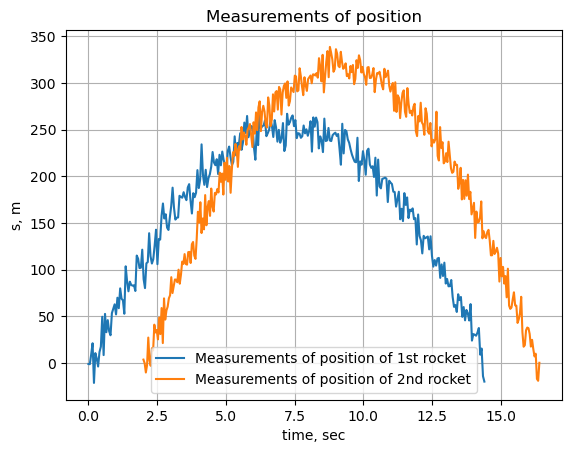

In [5]:
plt.figure()
plt.plot(t1, s1, label='Measurements of position of 1st rocket')
plt.plot(t2, s2, label='Measurements of position of 2nd rocket')
plt.title('Measurements of position')
plt.xlabel('time, sec')
plt.ylabel('s, m')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
def generate_deltaT(t):
    deltaT = np.zeros((1, 1, len(t)-1))
    
    for i in range(len(t)-1):
        deltaT[:, :, i] = t[i+1] - t[i]

    return deltaT

def generate_Fi(t):
    N = len(t[0, 0, :])
    Fi = np.zeros((3, 3, N))
    
    for i in range(N):
        Fi[:, :, i] = np.array([[1, t[0, 0, i], (t[0, 0, i]**2)/2],
                                [0, 1, t[0, 0, i]],
                                [0, 0, 1]])
    return Fi

In [7]:
def generate_Z(s,a):
    N = len(s)
    Z = np.zeros((2, 1, N))

    for i in range(N):
        Z[0, 0, i] = s[i]
        Z[1, 0, i] = a[i]
    return Z

In [21]:
#Kalman filter
def linear_kalmanFilter(Fi, H, R, X0, P0, Zm, N):
    Xp = np.zeros((3, 1, N))
    Xf = np.zeros((3, 1, N))
    
    Pf = np.zeros((3, 3, N))
    Pp = np.zeros((3, 3, N))
    K = np.zeros((3, 2, N))
    Ps = np.zeros((3, 1, N))
    Pf[:, :, 0] = P0
    Xf[:, :, 0] = X0
    
    for i in range(1, N):
        Xp[:, :, i] = np.dot(Fi[:, :, i-1], Xf[:, :, i-1])
        Pp[:, :, i] = np.dot(np.dot(Fi[:, :, i-1], Pf[:, :, i-1]), np.transpose(Fi[:, :, i-1])) + Q
        K[:, :, i] = np.dot(np.dot(Pp[:, :, i], np.transpose(H)), np.linalg.inv(np.dot(np.dot(H, Pp[:, :, i]), np.transpose(H)) + R))
        Xf[:, :, i] = Xp[:, :, i] + np.dot(K[:, :, i], (Zm[:, :, i] - np.dot(H, Xp[:, :, i])))
        Pf[:, :, i] = np.dot((np.eye(3) - np.dot(K[:, :, i], H)), Pp[:, :, i])
        Ps[:, :, i] = np.sqrt(np.abs(np.diag(Pf[:, :, i])[0]))
    
    return Xf, Xp, K, Ps, Pf,Pp

In [28]:
#Initial filtered estimate of state vector
X0 = np.array([[0],
              [0],
              [0]])

#Initial filtration error covariance matrix
P0 = np.array([[10**4, 0, 0],
               [0, 10**4, 0],
               [0, 0, 10**4]])

sigmaS = 12**2
sigmaA1 = 0.09**2

Q = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]])

#Measurement noise covariance matrix 
R1 = np.array([[sigmaS,0],
              [0,sigmaA1]])

# Transition matrix
deltaT1 = generate_deltaT(t1)
deltaT2 = generate_deltaT(t2)
Fi1 = generate_Fi(deltaT1)
Fi2 = generate_Fi(deltaT2)
    
# Observation matrix
H = np.array([[1, 0, 0],
              [0, 0, 1]])

In [29]:
Z1 = generate_Z(s1,a1)
Z2 = generate_Z(s2,a2)

In [56]:
Xf1, Xp1, K1, Ps1, Pf1, Pp1 = linear_kalmanFilter(Fi1, H, R1, X0, P0, Z1, n1)
Xf2, Xp2, K2, Ps2, Pf2, Pp2 = linear_kalmanFilter(Fi2, H, R1, X0, P0, Z2, n2)

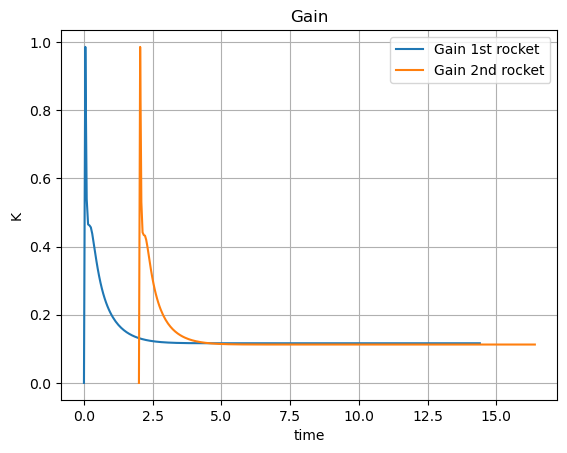

In [57]:
plt.figure()
plt.plot(t1, K1[0][0], label='Gain 1st rocket')
plt.plot(t2, K2[0][0], label='Gain 2nd rocket')
plt.title('Gain')
plt.xlabel('time')
plt.ylabel('K')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
sigmaS2 = 12**2
sigmaA2 = 5**2
R2 = np.array([[sigmaS2,0],
              [0,sigmaA2]])

Xf1, Xp1, K11, Ps1, Pf1, Pp1 = linear_kalmanFilter(Fi1, H, R2, X0, P0, Z1, n1)
Xf2, Xp2, K22, Ps2, Pf2, Pp2 = linear_kalmanFilter(Fi2, H, R2, X0, P0, Z2, n2)

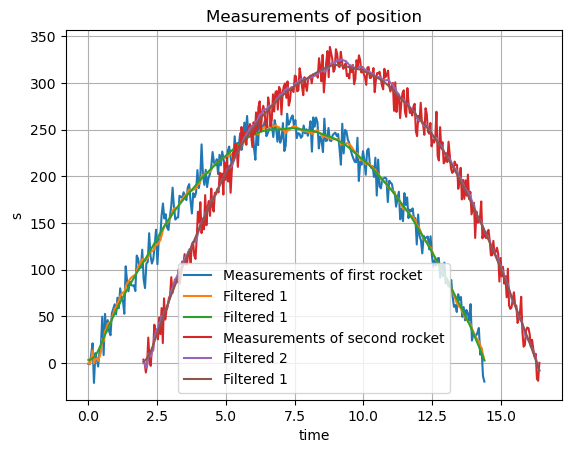

In [69]:
plt.figure()
plt.plot(t1, s1, label='Measurements of first rocket')
plt.plot(t1, Xf1[0][0], label='Filtered 1')
plt.plot(t1, Xb1[0][0], label='Filtered 1')
plt.plot(t2, s2, label='Measurements of second rocket')
plt.plot(t2, Xf2[0][0], label='Filtered 2')
plt.plot(t2, Xb2[0][0], label='Filtered 1')
plt.title('Measurements of position')
plt.xlabel('time')
plt.ylabel('s')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
def kalmanFilter_Backward(Xf, Xp, K, Ps, Pf, Pp, Fi, N):
    Pb = np.zeros((3, 3, N))
    A = np.zeros((3, 3, N))
    Xb = np.zeros((3, 1, N))
    
    
    Pb[:, :, N-1] = Pf[:, :, N-1]
    Xb[:, :, N-1] = Xf[:, :, N-1]
    
    for i in range(N-2, -1, -1):
        A[:, :, i] = np.dot(np.dot(Pf[:, :, i], Fi[:, :, i-1].T), np.linalg.inv(Pp[:, :, i+1]))
        Xb[:, :, i] = Xf[:, :, i] + np.dot(A[:, :, i], (Xb[:, :, i+1] - np.dot(Fi[:, :, i-1], Xf[:, :, i])))
        Pb[:, :, i] = Pf[:, :, i] + np.dot(A[:, :, i], (Pb[:, :, i+1] - np.dot(Pp[:, :, i+1], A[:, :, i].T)))
        Ps[:, :, i] = np.sqrt(np.abs(np.diag(Pb[:, :, i])[0]))
    return Xb, Pb, Ps, Xf

In [71]:
Xb1, Pb1, Ps_b1, Xf_1 = kalmanFilter_Backward(Xf1, Xp1, K1, Ps1, Pf1, Pp1, Fi1, n1)
Xb2, Pb2, Ps_b2, Xf_2 = kalmanFilter_Backward(Xf2, Xp2, K2, Ps2, Pf2, Pp2, Fi2, n2)

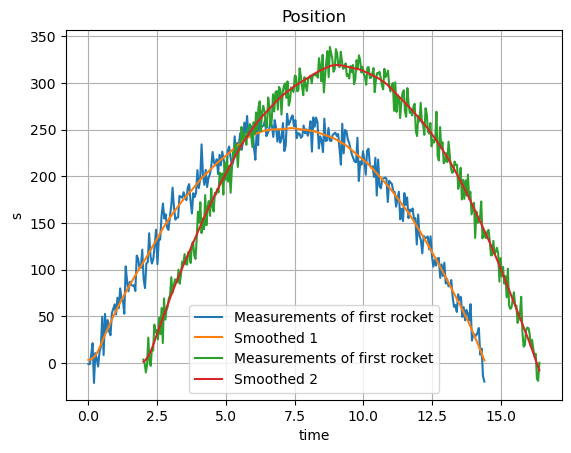

In [72]:
plt.figure()
plt.plot(t1, s1, label='Measurements of first rocket')
plt.plot(t1, Xb1[0][0], label='Smoothed 1')
plt.plot(t2, s2, label='Measurements of first rocket')
plt.plot(t2, Xb2[0][0], label='Smoothed 2')
plt.title('Position')
plt.xlabel('time')
plt.ylabel('s')
plt.legend()
plt.grid(True)
#plt.xlim(5,7)
#plt.ylim(200,300)
plt.show()


In [73]:
rocket1_position_interp = np.interp(t2, t1, Xb1[0,0,:])
rocket1_position_interp_forward = np.interp(t2, t1, Xf1[0,0,:])

In [74]:
error1 = np.zeros(n2)
error2 = np.zeros(n2)
for i in range(n2):
    error1[i] = np.abs(Xb2[0,0,i] - rocket1_position_interp[i])
    error2[i] = np.abs(Xb2[0,0,i] - rocket1_position_interp_forward[i])

In [75]:
for i in range(n2): 
    if error1[i] < 0.5 and i<300:
        print("Smoothing Filter:")
        print("The rockets meet at time of", t2[i], "seconds at an altitude of", rocket1_position_interp[i],".\n")
    if error2[i] < 0.5 and i<300:
        print("Kalman Filter:")
        print("The rockets meet at time of", t2[i], "seconds at an altitude of", rocket1_position_interp[i],".")
        
        #print("The rockets meet at time of", t2[i]+2, "seconds at an altitude of", int(rocket1_position_interp[i]),".")

Smoothing Filter:
The rockets meet at time of 5.699083 seconds at an altitude of 239.74104526892003 .

Kalman Filter:
The rockets meet at time of 5.787156 seconds at an altitude of 241.40417007176887 .


In [76]:
Accuracy_error1 = 0
Accuracy_error2 = 0

for i in range(n1):
    Accuracy_error1 += (Z1[0,0,i] - Xf1[0,0,i])**2  
    Accuracy_error2 += (Z1[0,0,i] - Xb1[0,0,i])**2
    
Accuracy_error1 = np.sqrt(Accuracy_error1/n1)
Accuracy_error2 = np.sqrt(Accuracy_error2/n1)

print("First rocket")
print("Error of Forward Kalman Filter:", Accuracy_error1)
print("Error Smoothing:", Accuracy_error2)

First rocket
Error of Forward Kalman Filter: 10.81255412706096
Error Smoothing: 11.539134746131772


In [66]:
Accuracy_error3 = 0
Accuracy_error4 = 0

for i in range(n1):
    Accuracy_error3 += (Z2[0,0,i] - Xf2[0,0,i])**2  
    Accuracy_error4 += (Z2[0,0,i] - Xb2[0,0,i])**2
    
Accuracy_error3 = np.sqrt(Accuracy_error3/n1)
Accuracy_error4 = np.sqrt(Accuracy_error4/n1)

print("Second rocket")
print("Error of Forward Kalman Filter:", Accuracy_error3)
print("Error Smoothing:", Accuracy_error4)

Second rocket
Error of Forward Kalman Filter: 10.32137320100927
Error Smoothing: 10.891482071514707


In [77]:
print("First rocket")

print("Apoogee using Smoothing:", max(Xb1[0][0]))
print("Apoogee using only Kalman filter:", max(Xf1[0][0]),"\n")

print("Second rocket")

print("Apoogee using Smoothing:", max(Xb2[0][0]))
print("Apoogee using only Kalman filter:", max(Xf2[0][0]))

First rocket
Apoogee using Smoothing: 251.48532886249723
Apoogee using only Kalman filter: 254.44733335941947 

Second rocket
Apoogee using Smoothing: 319.0591536868579
Apoogee using only Kalman filter: 324.9450409783032
